# 1. Data Pre-Processing 

In [65]:
# Dependencies
import os 
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np 
import random
import cv2
from tqdm import tqdm
import math
from datetime import datetime
import shutil
import imghdr

# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler


# Image augmentation 
import albumentations as A

# 1. Data pre-processing

* 1.0 Data exploration
* 1.1 Data Splitting (Train, Test, Validation)   Data Augmentation
* 1.2 Data Augmentation
* 1.3 Data Preparation

## 1.0 Data Exploration

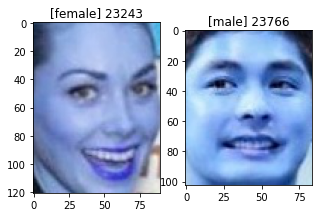

In [93]:
# Hype Paramters
DATA = os.path.join('data', 'Training')
CLASSES = os.listdir(DATA)
DATASET = 'dataset'
TRAINING_SET = os.path.join(DATASET, 'training')
TESTING_SET = os.path.join(DATASET, 'testing')
AUGMENTATION_MULTIPLIER = 3


def view_train_images():
      
    f, axarr = plt.subplots(nrows=1,ncols=len(CLASSES ), figsize=(5,5))
    for idx,category in enumerate(CLASSES):
          
      # path to the image
      images_path = os.path.join(DATA,category )
      images = os.listdir(images_path )
      example_img_path = os.path.join(images_path,random.choice( images ) )
      example_img = img.imread( example_img_path )

      # Plot example images 
      axarr[idx].set_title(f'[{category}] {len(images)}' )
      axarr[idx].imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB) )
      
view_train_images()

## 1.1 Data Splitting and Data Augmentation

In [127]:
def data_augmentation(file_dir, save_dir):
    # Reading the image 
    image = cv2.imread(file_dir ,cv2.COLOR_BGR2RGB)
    img_array = cv2.resize( image, (50,50)) 
    # Data augmentation with multiplier 
    for _ in range(AUGMENTATION_MULTIPLIER):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(),
            A.OpticalDistortion(),
            A.RandomScale(),
            A.GridDistortion(),
            A.RandomGamma(),
        ])
        transformed = transform(image=img_array )
        img_array_resize = cv2.resize(  transformed["image"], (50,50)) 
        file_name = f'{datetime.timestamp(datetime.now())}.jpg'
        file_path = os.path.join(save_dir,  file_name )
        cv2.imwrite(file_path, img_array_resize )
        
        
# Remvoe folder and create empty folder 
if os.path.exists(DATASET): 
    shutil.rmtree(DATASET, ignore_errors=True)
        
# Train 80% , Test 20%
for idx,category in enumerate(CLASSES):
    # path to the image
    images_path = os.path.join(DATA,category )
    list_images = os.listdir(images_path) 
    train_count = int(len(list_images)*0.80)
    
    train_images = list_images[:train_count]
    test_images = list_images[train_count:]
    
    training_set = os.path.join(TRAINING_SET, category)
    testing_set = os.path.join(TESTING_SET, category) 
    os.makedirs(training_set)
    os.makedirs(testing_set)
    
    for train_image_name in train_images:
        train_image_dir = os.path.join(images_path ,train_image_name)
        # Check if image 
        if imghdr.what(train_image_dir).lower().endswith(('png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif')):
            data_augmentation(train_image_dir, training_set )
    
    for test_image_name in test_images:
        test_image_dir = os.path.join(images_path ,test_image_name)
        # Check if image 
        if imghdr.what(test_image_dir).lower().endswith(('png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif')):
            data_augmentation(test_image_dir, testing_set )
        

In [138]:
for col in COLUMNS:
    testing_set = os.path.join(TESTING_SET, col)
    test_images = os.listdir(testing_set)
    print(f'Testing {col} : {len(test_images)}')
    
for col in COLUMNS:
    training_set = os.path.join(TRAINING_SET, col)
    train_images = os.listdir(training_set)
    print(f'Training {col} : {len(train_images)}')

Testing female : 13947
Testing male : 14262
Training female : 55782
Training male : 57036


## 1.3 Data Preparation

In [139]:
# Train data 
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_SET,
    target_size=(50,50),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

# Test data 
testing_dataget = ImageDataGenerator(rescale=1./255)
testing_generator = train_datagen.flow_from_directory(
    TESTING_SET ,
    target_size=(50,50),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 112818 images belonging to 2 classes.
